In [1]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

import warnings

warnings.filterwarnings("ignore")

# For embeddings and similarity computation
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity

    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print(
        "Please install with: pip install sentence-transformers scikit-learn networkx"
    )

Required libraries imported successfully!


In [2]:
def load_corpus(file_path: str) -> dict[str, dict]:
    """
    TODO

    Load corpus data from JSONL file.
    Returns dictionary mapping document IDs to document data.
    """
    corpus = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            line = line.strip()
            obj = json.loads(line)
            docid = str(obj["_id"])
            corpus[docid] = obj
    return corpus


def load_queries(file_path: str) -> dict[str, dict]:
    """
    TODO

    Load query data from JSONL file.
    Returns dictionary mapping query IDs to query data.
    """
    queries = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            line = line.strip()
            obj = json.loads(line)
            qid = str(obj["_id"])
            queries[qid] = obj
    return queries


def load_qrels(file_path: str) -> dict[str, dict[str, int]]:
    """
    TODO

    Load relevance judgments from TSV file.
    Returns dictionary mapping query IDs to candidate relevance scores.
    """
    qrels = defaultdict(dict)
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines[1:]:
            qid, docid, score = line.strip().split("\t")
            qrels[qid][docid] = int(score)
    return qrels


print("Loading dataset...")
corpus = load_corpus('./data/corpus.jsonl')
queries = load_queries('./data/queries.jsonl')
qrels_valid = load_qrels('./data/valid.tsv')


print(f"Loaded {len(corpus)} documents in corpus")
print(f"Loaded {len(queries)} queries")
print(f"Loaded relevance for {len(qrels_valid)} queries (dataset)")

Loading dataset...
Loaded 25657 documents in corpus
Loaded 1000 queries
Loaded relevance for 700 queries (dataset)


In [3]:
def calculate_average_proportions(qrels: dict[str, dict[str, int]]) -> tuple[float]:
    """
    Calculate the proportion of relevant documents in average across all queries.
    """
    total_relevant = 0
    total_irrelevant = 0
    total_documents = 0

    for query_id, doc_scores in qrels.items():
        relevant_docs = sum(1 for score in doc_scores.values() if score == 1)
        irrelevant_docs = sum(1 for score in doc_scores.values() if score == 0)
        total_relevant += relevant_docs
        total_irrelevant += irrelevant_docs
        total_documents += len(doc_scores)

    avg_proportion_relevant = total_relevant / total_documents if total_documents > 0 else 0
    avg_proportion_irrelevant = total_irrelevant / total_documents if total_documents > 0 else 0

    return avg_proportion_relevant, avg_proportion_irrelevant

avg_proportion_relevant,avg_proportion_irrelevant = calculate_average_proportions(qrels_valid)
print(f"Average proportion of relevant documents across all queries: {avg_proportion_relevant:.4f}")
print(f"Average proportion of irrelevant documents across all queries: {avg_proportion_irrelevant:.4f}")

Average proportion of relevant documents across all queries: 0.1647
Average proportion of irrelevant documents across all queries: 0.8353


In [4]:
def fetch_query_data(query_id: str, qrels:dict[str, dict[str, int]],queries:dict[str, dict], corpus:dict[str, dict] ) -> dict:
    """
    Fetch query text and associated metadata given a query ID.
    """
    if query_id not in queries:
        raise ValueError(f"Query ID {query_id} not found in queries.")
    linked_documents = qrels.get(query_id, {})
    query_data = {
        "query": queries[query_id],
        "linked_documents": {
            "relevant": [],
            "irrelevant": []
        }
    }
    for doc_id in linked_documents:
        if doc_id in corpus:
            doc_data = corpus[doc_id]
            if linked_documents[doc_id] == 1:
                query_data["linked_documents"]["relevant"].append(doc_data)
            else:
                query_data["linked_documents"]["irrelevant"].append(doc_data)
    return query_data

first_id = list(queries.keys())[0]

query_data = fetch_query_data(first_id, qrels_valid, queries, corpus)
print(f"Query ID: {first_id}")
print(f"Query Text: {query_data['query']['text']}")
print(f"Number of Relevant Documents: {len(query_data['linked_documents']['relevant'])}")
print(f"Number of Irrelevant Documents: {len(query_data['linked_documents']['irrelevant'])}")
relevant_titles = [doc['title'] for doc in query_data['linked_documents']['relevant']]
irrelevant_titles = [doc['title'] for doc in query_data['linked_documents']['irrelevant']]
print(f"Relevant Document Titles:\n{'\n'.join(relevant_titles)}\n\n")
print(f"Irrelevant Document Titles:\n{'\n'.join(irrelevant_titles)}")

Query ID: 78495383450e02c5fe817e408726134b3084905d
Query Text: A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect
Number of Relevant Documents: 5
Number of Irrelevant Documents: 25
Relevant Document Titles:
A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
A modified particle swarm optimizer
Identification and control of dynamic systems using recurrent fuzzy neural networks
Genetic Fuzzy Systems - Evolutionary Tuning and Learning of Fuzzy Knowledge Bases
A hybrid of genetic algorithm and particle swarm optimization for recurrent network design


Irrelevant Document Titles:
A data mining approach for location prediction in mobile environments
Treatment-Response Models for Counterfactual Reasoning with Continuous-time, Continuous-valued Interventions
Dissecting and Reassembling Color Correction Algorithms for Image Stitching
A Database of Narrative Schemas
Automatic Machine Translation Evaluation: A Qualitative Approach
Mea

In [12]:
# import nltk
# nltk.download('punkt_tab')
# stemmer = nltk.PorterStemmer()

vectorizer = CountVectorizer(
    stop_words='english',
    lowercase=True,
    token_pattern=r'\b\w{3,}\b',  # Tokens of at least 3 characters
    # tokenizer= lambda text: [stemmer.stem(token) for token in nltk.word_tokenize(text)]
)
def compute_term_document_matrix(corpus: dict[str, dict]) -> np.ndarray:
    """
    Compute the term-document matrix for the given corpus.
    Each row corresponds to a document, and each column corresponds to a term.
    The value at (i, j) represents the frequency of term j in document i.
    """
    documents = [f"{doc_data['title']} {doc_data['text']}" for doc_id, doc_data in corpus.items()]
    term_document_matrix = vectorizer.fit_transform(documents)
    return term_document_matrix.toarray()

term_document_matrix = compute_term_document_matrix(corpus)
print(f"Term-Document Matrix shape: {term_document_matrix.shape}")
# print(f"Term-Document Matrix sum: {np.sum(term_document_matrix)}")

Term-Document Matrix shape: (25657, 76703)
Term-Document Matrix sum: 2711774


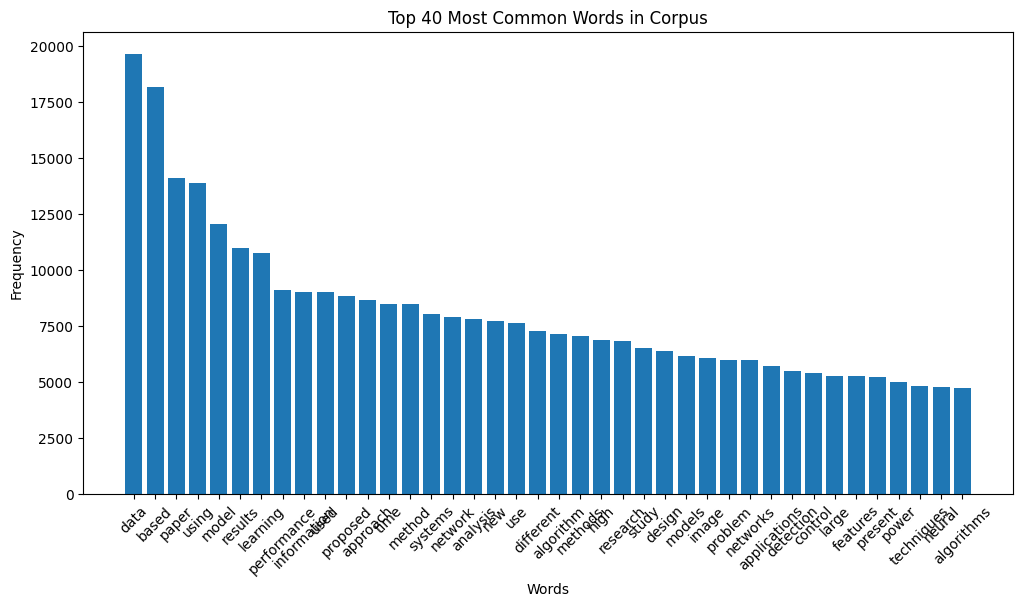

In [6]:
def plot_word_distribution(term_document_matrix: np.ndarray, top_n: int = 20):
    """
    Plot the distribution of the most common words in the corpus.
    """
    import matplotlib.pyplot as plt

    word_counts = np.sum(term_document_matrix, axis=0)
    terms = vectorizer.get_feature_names_out()
    word_count_dict = dict(zip(terms, word_counts))
    most_common_words = Counter(word_count_dict).most_common(top_n)
    words, counts = zip(*most_common_words)
    
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f'Top {top_n} Most Common Words in Corpus')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

plot_word_distribution(term_document_matrix, top_n=40)

Removing common words: ('data', 'based', 'paper', 'using', 'model', 'results', 'learning')
33788
Least common words (frequency <= 1): ('00000', '000001', '000002', '00003', '00003545', '00013', '000158', '00016', '00044', '00052', '000532', '00058', '00068', '0007', '000buildings', '000mhz', '000sf', '000users', '000x', '00112', '00120', '0013916502238864', '0014', '00140', '0016λ', '0017', '0019', '0020', '0021', '0021mum2', '00225610', '00228', '0025', '0028680', '0030', '003140', '00316', '0033', '0035', '0039', '003deg', '003degc', '0040', '0041', '004216', '0049', '0065', '00672', '006degc', '0070', '00703', '0078', '0078296', '0092', '0093400', '0094', '00961', '00pm', '00x', '01002', '01062', '0108', '01100', '0113', '0114', '01149', '01195', '0124', '0137λo', '013λo', '0140', '0141', '0152', '0156g', '01587', '0160', '016109', '0167', '016λ', '0171', '0180', '018203jes', '019', '0192', '01923', '0193', '0195', '0199', '01991', '019λo', '01er25486', '01fc', '01mm', '0200', '0201

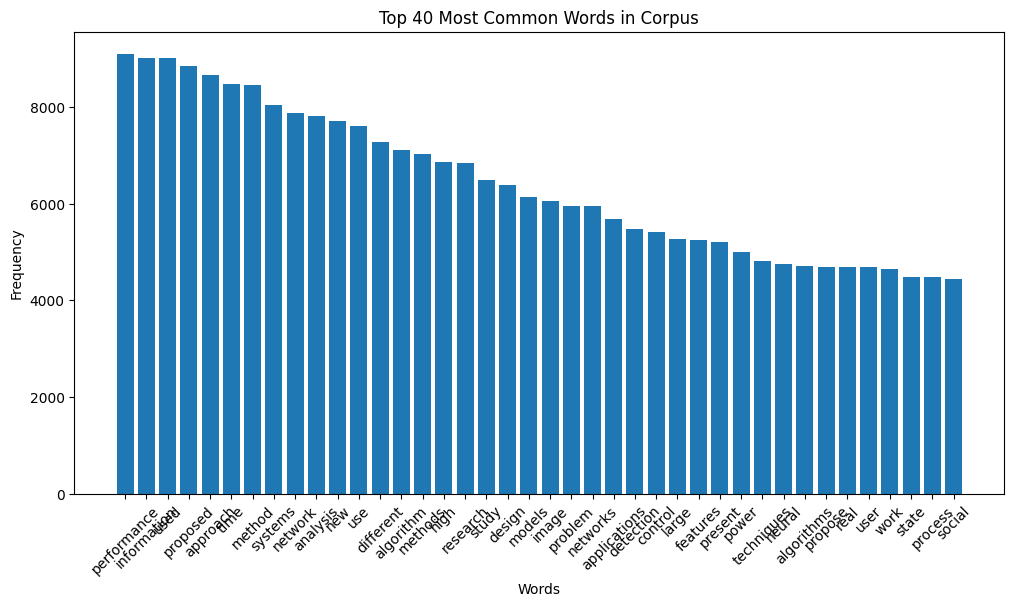

In [13]:
# delete vectors data for too common words
def clean_term_document_matrix(corpus: dict[str, dict], term_document_matrix: np.ndarray, top_n: int, least_count: int) -> np.ndarray:
    """
    Remove columns corresponding to common words from the term-document matrix.
    """
    word_counts = np.sum(term_document_matrix, axis=0)
    terms = vectorizer.get_feature_names_out()
    word_count_dict = dict(zip(terms, word_counts))
    sorted_words = Counter(word_count_dict).most_common()
    most_common_words = sorted_words[:top_n]
    most_words, _ = zip(*most_common_words)
    print(f"Removing common words: {most_words}")
    least_common_words = [word for word in sorted_words if word[1] <= least_count]
    print(len(least_common_words))
    least_common,_ = zip(*least_common_words)
    print(f"Least common words (frequency <= {least_count}): {least_common}")
    return [term for term in terms if term not in most_words+least_common]


cleaned_term = clean_term_document_matrix(corpus, term_document_matrix, top_n=7, least_count=1)
vectorizer = CountVectorizer(
    stop_words='english',
    lowercase=True,
    token_pattern=r'\b\w{3,}\b',
    vocabulary=cleaned_term
)
documents = [f"{doc_data['title']} {doc_data['text']}" for _, doc_data in corpus.items()]
cleaned_term_document_matrix = vectorizer.fit_transform(documents).toarray()
print(f"Term-Document Matrix shape: {cleaned_term_document_matrix.shape}")
# print(f"Term-Document Matrix sum: {np.sum(cleaned_term_document_matrix)}")

plot_word_distribution(cleaned_term_document_matrix, top_n=40)

In [14]:
def text_similarity(text1_index: int, text2_index: int, term_document_matrix: np.ndarray) -> float:
    """
    Compute the cosine similarity between two texts using sentence embeddings.
    """
    vec1 = term_document_matrix[text1_index].reshape(1, -1)
    vec2 = term_document_matrix[text2_index].reshape(1, -1)
    similarity = cosine_similarity(vec1, vec2)[0][0]
    return similarity

relevant_text1_id = query_data['linked_documents']['relevant'][0]['_id']
relevant_text2_id = query_data['linked_documents']['relevant'][1]['_id']
irrelevant_text1_id = query_data['linked_documents']['irrelevant'][0]['_id']

relevant_text1_index = list(corpus.keys()).index(relevant_text1_id)
relevant_text2_index = list(corpus.keys()).index(relevant_text2_id)
irrelevant_text1_index = list(corpus.keys()).index(irrelevant_text1_id)
similarity_score = text_similarity(relevant_text1_index, relevant_text2_index, cleaned_term_document_matrix)
print(f"Cosine similarity between document {relevant_text1_id} and {relevant_text2_id}: {similarity_score:.4f}")
print(corpus[relevant_text1_id]['title'])
print(corpus[relevant_text2_id]['title'])
similarity_score_irrelevant = text_similarity(relevant_text1_index, irrelevant_text1_index, cleaned_term_document_matrix)
print(f"Cosine similarity between document {relevant_text1_id} and {irrelevant_text1_id}: {similarity_score_irrelevant:.4f}")
print(corpus[irrelevant_text1_id]['title'])


Cosine similarity between document 86e87db2dab958f1bd5877dc7d5b8105d6e31e46 and 506172b0e0dd4269bdcfe96dda9ea9d8602bbfb6: 0.0392
A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
A modified particle swarm optimizer
Cosine similarity between document 86e87db2dab958f1bd5877dc7d5b8105d6e31e46 and 1ae0ac5e13134df7a0d670fc08c2b404f1e3803c: 0.0515
A data mining approach for location prediction in mobile environments


In [15]:
print(query_data['query']['text'])
query_vec = vectorizer.transform([query_data['query']['text']]).toarray()
for document in query_data['linked_documents']['relevant']:
    doc_id = document['_id']
    doc_index = list(corpus.keys()).index(doc_id)
    similarity = cosine_similarity(query_vec, cleaned_term_document_matrix[doc_index].reshape(1, -1))[0][0]
    print(f"Cosine similarity between query and relevant document {doc_id}: {similarity:.4f}")

A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect
Cosine similarity between query and relevant document 86e87db2dab958f1bd5877dc7d5b8105d6e31e46: 0.2219
Cosine similarity between query and relevant document 506172b0e0dd4269bdcfe96dda9ea9d8602bbfb6: 0.0000
Cosine similarity between query and relevant document 51317b6082322a96b4570818b7a5ec8b2e330f2f: 0.0414
Cosine similarity between query and relevant document 2a047d8c4c2a4825e0f0305294e7da14f8de6fd3: 0.0000
Cosine similarity between query and relevant document 632589828c8b9fca2c3a59e97451fde8fa7d188d: 0.0147


In [16]:
def first_search_engine(query: str, corpus: dict[str, dict],term_document_matrix: np.ndarray, top_k: int = 5) -> list[tuple[str, float]]:
    """
    A simple search engine that retrieves the top_k most similar documents to the query
    based on cosine similarity of term-document vectors.
    """
    query_vec = vectorizer.transform([query]).toarray()
    print(f"Query Vector shape: {query_vec.shape}")
    similarities = cosine_similarity(query_vec, term_document_matrix)[0]
    print(f"Similarities shape: {similarities.shape}")
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    results = [(list(corpus.keys())[i], similarities[i]) for i in top_indices]
    return results

results = first_search_engine(query_data['query']['text'], corpus, cleaned_term_document_matrix, top_k=10)
print("Top 10 search results:")
for doc_id, score in results:
    print(f"Document ID: {doc_id}, Similarity Score: {score:.4f}, Title: {corpus[doc_id]['title']}")
relevant_article_count = sum(1 for doc_id, score in results if doc_id in [doc['_id'] for doc in query_data['linked_documents']['relevant']])
print(f"Number of relevant articles in top 10 results: {relevant_article_count}")

Query Vector shape: (1, 42908)
Similarities shape: (25657,)
Top 10 search results:
Document ID: eef39364df06eb9933d2fc41a0f13eea17113c58, Similarity Score: 0.3414, Title: Credit scoring using support vector machines with direct search for parameters selection
Document ID: 9981e27f01960526ea68227c7f8120e0c3ffe87f, Similarity Score: 0.3024, Title: Golden section search over hyper-rectangle: a direct search method
Document ID: be32610fb5cdc850538ace1781fbfd5b96698618, Similarity Score: 0.2806, Title: A descent modified
Document ID: 371d0da66420ed6885c4badc3d4b7eb086d4292c, Similarity Score: 0.2697, Title: An Efficient Privacy-Preserving Ranked Keyword Search Method
Document ID: 2a43d3905699927ace64e880fe9ba8a730e14be1, Similarity Score: 0.2663, Title: Distributed Event-Triggered Scheme for Economic Dispatch in Smart Grids
Document ID: f78f63a2a4093ec549ff2eaa683b247c9612a9ce, Similarity Score: 0.2632, Title: A high-accuracy method for fine registration of overlapping point clouds
Document

# Représentation Dense

In [17]:
model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_sentence_embeddings(corpus: dict[str, dict], model: SentenceTransformer) -> np.ndarray:
    """
    Compute sentence embeddings for each document in the corpus using the provided model.
    """
    documents = [f"{doc_data['title']} {doc_data['text']}" for doc_id, doc_data in corpus.items()]
    embeddings = model.encode(documents, convert_to_numpy=True)
    return embeddings
sentence_embeddings = compute_sentence_embeddings(corpus, model)
print(f"Sentence Embeddings shape: {sentence_embeddings.shape}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Sentence Embeddings shape: (25657, 384)


In [18]:
pickle.dump(sentence_embeddings, open('./data/sentence_embeddings_all-MiniLM-L6-v2.pkl', 'wb'))

In [ ]:
sentence_embeddings = pickle.load(open('./data/sentence_embeddings_all-MiniLM-L6-v2.pkl', 'rb'))

In [20]:
def second_search_engine(query: str, corpus: dict[str, dict], embeddings: np.ndarray, model: SentenceTransformer, top_k: int = 5) -> list[tuple[str, float]]:
    """
    A search engine that retrieves the top_k most similar documents to the query
    based on cosine similarity of sentence embeddings.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    results = [(list(corpus.keys())[i], similarities[i]) for i in top_indices]
    return results

results = second_search_engine(query_data['query']['text'], corpus, sentence_embeddings, model, top_k=10)
print("Top 10 search results (Sentence Embeddings):")
for doc_id, score in results:
    print(f"Document ID: {doc_id}, Similarity Score: {score:.4f}, Title: {corpus[doc_id]['title']}")
relevant_article_count = sum(1 for doc_id, score in results if doc_id in [doc['_id'] for doc in query_data['linked_documents']['relevant']])
print(f"Number of relevant articles in top 10 results: {relevant_article_count}")

Top 10 search results (Sentence Embeddings):
Document ID: 86e87db2dab958f1bd5877dc7d5b8105d6e31e46, Similarity Score: 0.5769, Title: A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
Document ID: cd31ecb3b58d1ec0d8b6e196bddb71dd6a921b6d, Similarity Score: 0.4477, Title: Economic dispatch for a microgrid considering renewable energy cost functions
Document ID: 1f376c10b20319121102db78e7790cf47d8fa046, Similarity Score: 0.4378, Title: Optimal Reconfiguration for Supply Restoration With Informed A$^{\ast}$  Search
Document ID: 91de962e115bcf65eaf8579471a818ba8c5b0ea6, Similarity Score: 0.4209, Title: Cuckoo search algorithm: a metaheuristic approach to solve structural optimization problems
Document ID: 3fd46ca896d023df8c8af2b3951730d8c38defdd, Similarity Score: 0.4119, Title: Training neural nets with the reactive tabu search
Document ID: 2a43d3905699927ace64e880fe9ba8a730e14be1, Similarity Score: 0.4098, Title: Distributed Event-Triggered Scheme for Eco

In [24]:
score = 0
for i,query in enumerate(queries.values()):
    results = second_search_engine(query['text'], corpus, sentence_embeddings, model, top_k=10)
    relevant_article_count = sum(1 for doc_id, score in results if doc_id in qrels_valid.get(str(query['_id']), {}) and qrels_valid[str(query['_id'])][doc_id] == 1)
    # print(f"Query ID: {query['_id']}, Number of relevant articles in top 10 results: {relevant_article_count}")
    score += relevant_article_count
    if i % 100 == 0:
        print(f"Processed {i} queries...")
print(f"Total score across all queries: {score}")
print(f"Total score across all queries: {score/(len(queries)*10)}")

Processed 0 queries...
Processed 100 queries...
Processed 200 queries...
Processed 300 queries...
Processed 400 queries...
Processed 500 queries...
Processed 600 queries...
Processed 700 queries...
Processed 800 queries...
Processed 900 queries...
Total score across all queries: 769
Total score across all queries: 0.0769
